# collection of recipes from class notes

## 0. Common Setup

In [1]:
%matplotlib inline

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
import functools
from glob import glob

from skimage.measure import LineModel, ransac
from sklearn.cluster import KMeans

In [3]:
test_imgs = [cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) 
                   for f in glob("test_images/*.jpg")]

### Conventions
Except explictly stated, all image inputs to the methods in this note will be RGB

### genearal pipeline function

In [4]:
def make_pipeline(steps):
    """Create a pipeline composed of each step
    """
    def compose2(f, g):
        return lambda x: g(f(x))
    return functools.reduce(compose2, steps)
def AND(f, g):
    """Return the AND operation result of two steps
    """
    def _and(x):
        return f(x) & g(x)
    return _and
def OR(f, g):
    """Return the OR operation result of two steps
    """
    def _or(x):
        return f(x) | g(x)
    return _or

In [5]:
## test make a pipe
fs = [lambda x, i=i: "%s -> f%d" % (x, i) for i in range(10)]
p = make_pipeline(fs)
p("s")

's -> f0 -> f1 -> f2 -> f3 -> f4 -> f5 -> f6 -> f7 -> f8 -> f9'

## 1. Camera Calibration

In [6]:
class CameraCalibrator(object):
    """Calibrate camera by estimating the distortion
    matrix and coefficients.
    """
    def __init__(self):
        """Class members:
        `self.M`: distortion matrix
        `self.d`: distortion coefficients
        """
        self.M = None
        self.d = None
    def fit(self, chessboard_images, nx=9, ny=6, img_size=None):
        """Estimate distortion matrix and coefficients
        by training on a set of chessboard images.
        `chessboard_images`: list of RGB images, assuming they
          are from the same chessboard and same camera, and of
          roughly the same size.
        `nx`,`ny`: number of corners in x and y directions
        """
        if img_size == None:
            h, w = chessboard_images[0].shape[:2]
            img_size = (w, h)
        objp = np.array([(x, y, 0) for y in range(ny) for x in range(nx)], dtype=np.float32)
        objpts, imgpts = [], []
        for img in chessboard_images:
            # convert to gray and find corner points
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
            if ret:
                objpts.append(objp)
                imgpts.append(corners)
                cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            else:
                # ignore images that cannot be used
                print("Cannot find corner points in image")
        ret, self.M, self.d, rvecs, tvecs = cv2.calibrateCamera(objpts, imgpts, img_size, None, None)
        return self
    def save(self, model_file):
        model = {"M": self.M, "d": self.d}
        pickle.dump(model, open(model_file, "wb"))
        print("calibration model saved at %s" % model_file)
        return self
    def restore(self, model_file):
        model = pickle.load(open(model_file, "rb"))
        self.M = model["M"]
        self.d = model["d"]
        print("calibration model restored from %s" % model_file)
        return self
    def undistort(self, img):
        """img: original RGB img to be undistorted
        Return undistorted image.
        """
        undist = cv2.undistort(img, self.M, self.d, None, self.M)
        return undist

### test camera calibration

Cannot find corner points in image
Cannot find corner points in image
calibration model saved at tmp/camera_calibrator.p
calibration model restored from tmp/camera_calibrator.p


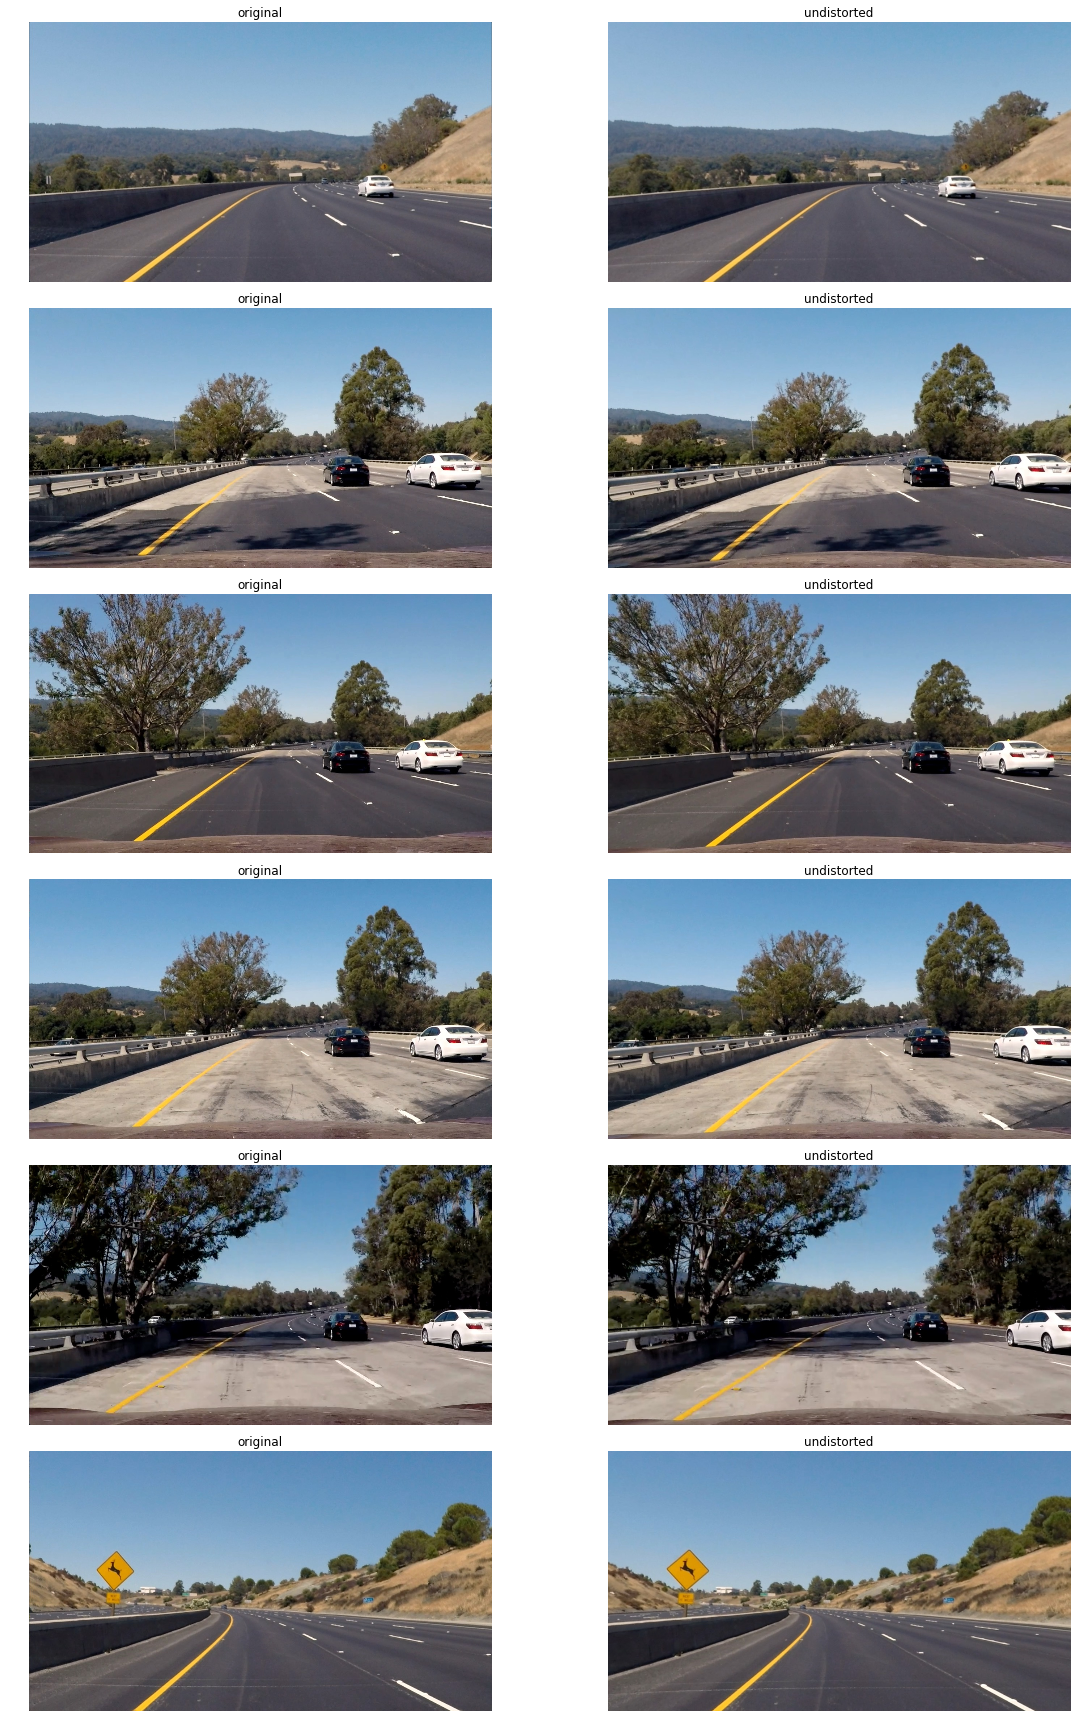

In [7]:
from glob import glob
chessboard_imgs = [cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB) 
                   for f in glob("camera_cal/*.jpg")]
cc = CameraCalibrator()
cc.fit(chessboard_imgs)
cc.save("tmp/camera_calibrator.p")
cc.restore("tmp/camera_calibrator.p")


fig, axes = plt.subplots(6, 2, figsize = (8*2, 4*6))
fig.tight_layout()
fig.subplots_adjust(wspace = 0.1, hspace=0.1, )
for ax, test_img in zip(axes, test_imgs):
    ax[0].imshow(test_img)
    ax[0].set_title("original")
    ax[0].set_axis_off()
    undist = cc.undistort(test_img)
    ax[1].imshow(undist)
    ax[1].set_title("undistorted")
    ax[1].set_axis_off()

## 2. Line Detection

In [8]:
class LineDetector(object):
    """Detect lines (e.g. lane boundaries) in images using a combination 
    of different methods. It supports different line detection 
    algorithms and their combinations. For now the user needs 
    to pre-configure the methods beforehand, it may support 
    automated algorithm selection based on images in the future.
    
    There are three main steps in configuring a line detector:
        - convert color images to gray, e.g, by RGB->gray or HLS->S
        - line detection, e.g., canny, sobel_x, sobel_y, sobel_magnitude, sobel_dir
        - filtering, e.g., by threshold of pixel, line oritentation, etc.
    A pipeline can be built by setting different choices at each setp.
    A combination can be done by using AND/OR operations on the resulted line(binary) images.
    The combination also has a smoothing effect like Gaussian filtering. Using a larger
    `ksize` has the same effect.
    """
    def __init__(self):
        pass
    def gray_converter(self, gray_type):
        """Create gray_image_converter for line detecion pipeline.
        `gray_type`: {"gray", "saturation", "hue"}.
        Returns a gray image converter function with RGB image input
            and a gray image output 
        """
        gray_type = gray_type.lower()
        def f(img):
            if gray_type == "gray":
                return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            elif gray_type == "saturation":
                return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:, :, 2]
            elif gray_type == "hue":
                return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:, :, 0]
            elif gray_type == "lightness":
                return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:, :, 1]
            else:
                raise ValueError("Unknown gray_type %s" % gray_type)
        return f
    def sobel_detector(self, sobel_type, ksize=3):
        """Create sobel based line dector for line detection pipeline.
        `sobel_type`: {"x", "y", "magnitude", "direction"}.
        `ksize`: kernel size for Sobel filter, default to 3
        Returns a function with gray image input and a Sobel image output, 
            the pixels of Sobel image is within [-$\pi$/2, $\pi$/2] for 'direction'
            and [0, 255] for other sobel_types
        """
        sobel_type = sobel_type.lower()
        def f(gray):
            sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
            sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
            if sobel_type == "x":
                sobel = np.absolute(sobelx)
            elif sobel_type == "y":
                sobel = np.absolute(sobely)
            elif sobel_type == "magnitude":
                sobel = np.sqrt(sobelx*sobelx + sobely*sobely)
            elif sobel_type == "direction":
                sobel = np.arctan(sobely / (sobelx + 1e-6))
            else:
                raise ValueError("Unknown sobel_type %s" % sobel_type)
            # normalize sobel as a normal gray image, so it can be visualized
            if sobel_type in ["x", "y", "magnitude"]:
                sobel = (sobel * 255. / sobel.max()).astype(np.uint8)
            return sobel
        return f
    def threshold_filter(self, lower, upper):
        """Create binary filter for line detection pipeline.
        `lower`, `upper` are bounds for pixel value (distributed between 0, 255).
        Returns a function that returns a binary image, where pixels in [lower, upper]
        are 1 and the rest are 0.
        """
        def f(gray):
            binary = (gray >= lower) & (gray <= upper)
            return binary
        return f

### test line detector

In [9]:
ld = LineDetector()

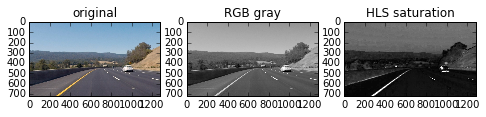

In [10]:
## test gray converter
rgb_gray_converter = ld.gray_converter("gray")
hls_gray_converter = ld.gray_converter("saturation")
test_img = test_imgs[0]
rgb_gray = rgb_gray_converter(test_img)
hls_gray = hls_gray_converter(test_img)
fig, axes = plt.subplots(1, 3, figsize=(8*1, 3*4))
axes[0].imshow(test_img)
axes[0].set_title("original")
axes[1].imshow(rgb_gray, cmap=plt.cm.gray)
axes[1].set_title("RGB gray")
axes[2].imshow(hls_gray, cmap=plt.cm.gray)
axes[2].set_title("HLS saturation")

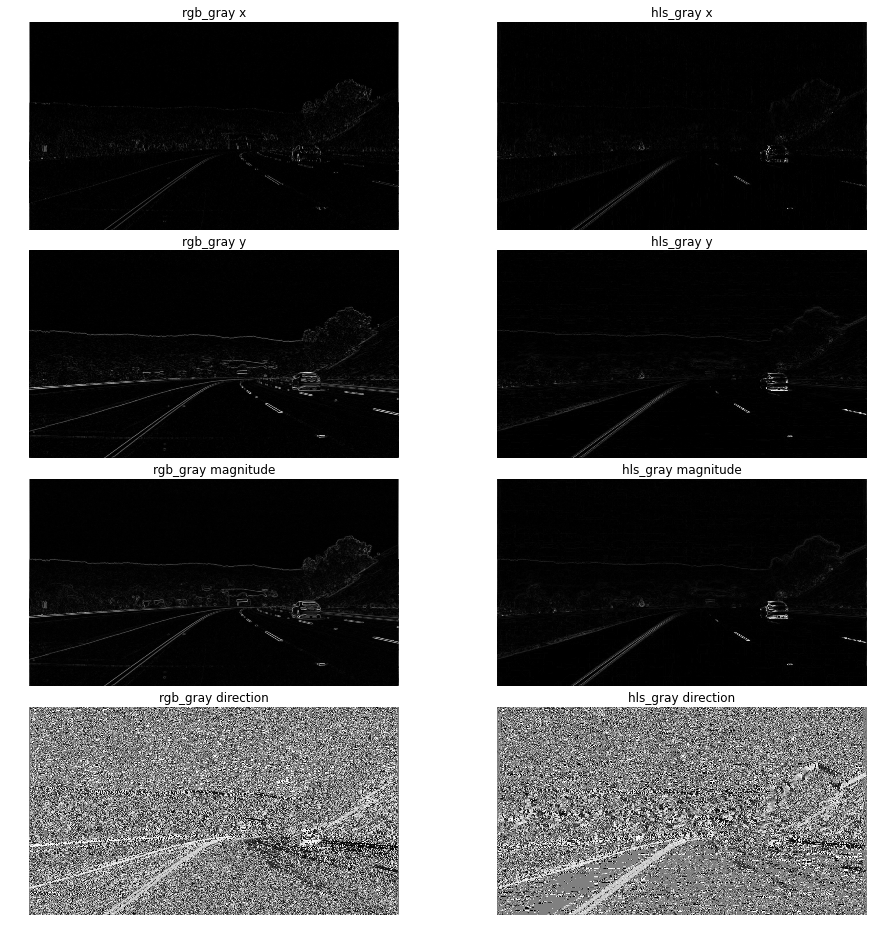

In [11]:
## test sobel filter
fig, axes = plt.subplots(4, 2, figsize=(2*8, 4 * 4))
fig.subplots_adjust(wspace=0.1, hspace=0.1)
gray_imgs = [("rgb_gray", rgb_gray), ("hls_gray", hls_gray)]
sobels = [(s, ld.sobel_detector(s)) for s in ["x", "y", "magnitude", "direction"]]
for c, (gray_type, gray_img) in enumerate(gray_imgs):
    for r, (sobel_type, sobel_fn) in enumerate(sobels):
        sobel = sobel_fn(gray_img)
        axes[r,c].imshow(sobel, cmap=plt.cm.gray)
        axes[r,c].set_title("%s %s" % (gray_type, sobel_type))
        axes[r,c].set_axis_off()

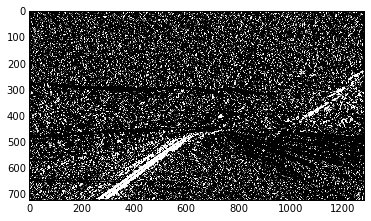

In [12]:
## test make a line detector by piping different steps

directional_line_detector = make_pipeline([
    ld.gray_converter("gray")
    , ld.sobel_detector("direction", ksize=15)
    , ld.threshold_filter(0.7, 1.2)
#     , ld.threshold_filter(-1.2, 0.7)
])

directional_line_img = directional_line_detector(test_imgs[0])
plt.imshow(directional_line_img, cmap=plt.cm.gray)

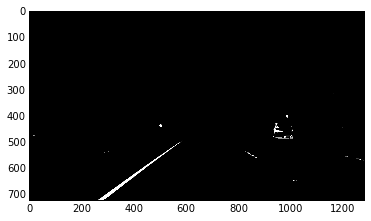

In [13]:

color_line_detector = make_pipeline([
    ld.gray_converter("saturation")
    , ld.threshold_filter(175, 255)
])

color_line_img = color_line_detector(test_imgs[0])
plt.imshow(color_line_img, cmap=plt.cm.gray)

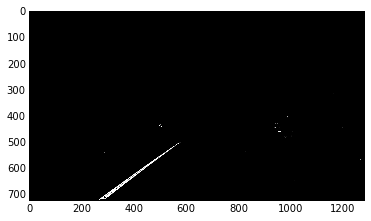

In [14]:
# combination
combined_line = directional_line_img&color_line_img
plt.imshow(combined_line, cmap=plt.cm.gray)

### observations
two steps
- make all lines that should be detected visible
- remove noise

some tricks
- color_detector is going to help a lot with reducing noise, e.g., trees that have dark colors

In [15]:
# it seems to be a good detector by combining lightness, 
# saturation channel and directional filtering


ld = LineDetector()

ksize = 11
gradx_detector1 = make_pipeline([
        ld.gray_converter("lightness")
        , ld.sobel_detector("x", ksize=ksize)
        , ld.threshold_filter(25, 125)
])
left_dir_detector1 = make_pipeline([
        ld.gray_converter("lightness")
        , ld.sobel_detector("direction", ksize=ksize)
        , ld.threshold_filter(0.3, 1.5)
#         , ld.threshold_filter(0.7, 1.2)
        
])
right_dir_detector1 = make_pipeline([
        ld.gray_converter("lightness")
        , ld.sobel_detector("direction", ksize=ksize)
        , ld.threshold_filter(-1.5, -0.3)    
])
line_detector1 = AND( gradx_detector1, OR(left_dir_detector1, right_dir_detector1))

gradx_detector2 = make_pipeline([
        ld.gray_converter("saturation")
        , ld.sobel_detector("x", ksize=ksize)
        , ld.threshold_filter(25, 125)
])
left_dir_detector2 = make_pipeline([
        ld.gray_converter("saturation")
        , ld.sobel_detector("direction", ksize=ksize)
        , ld.threshold_filter(0.3, 1.5)
#         , ld.threshold_filter(0.7, 1.2)
])
right_dir_detector2 = make_pipeline([
        ld.gray_converter("saturation")
        , ld.sobel_detector("direction", ksize=ksize)
        , ld.threshold_filter(-1.5, -0.3)
        
])
line_detector2 = AND( gradx_detector2, OR(left_dir_detector2, right_dir_detector2))

line_detector = OR(line_detector1, line_detector2)

# H, W = test_imgs[0].shape[:2]
# roi = np.array([[(0,H), (W/2-40, H/2+40), (W/2+40, H/2+40),(W,H)]], dtype=np.int32)
# trapezoidal_roi_cropper = ld.roi_cropper(roi)
# line_detector = make_pipeline([line_detector, trapezoidal_roi_cropper])

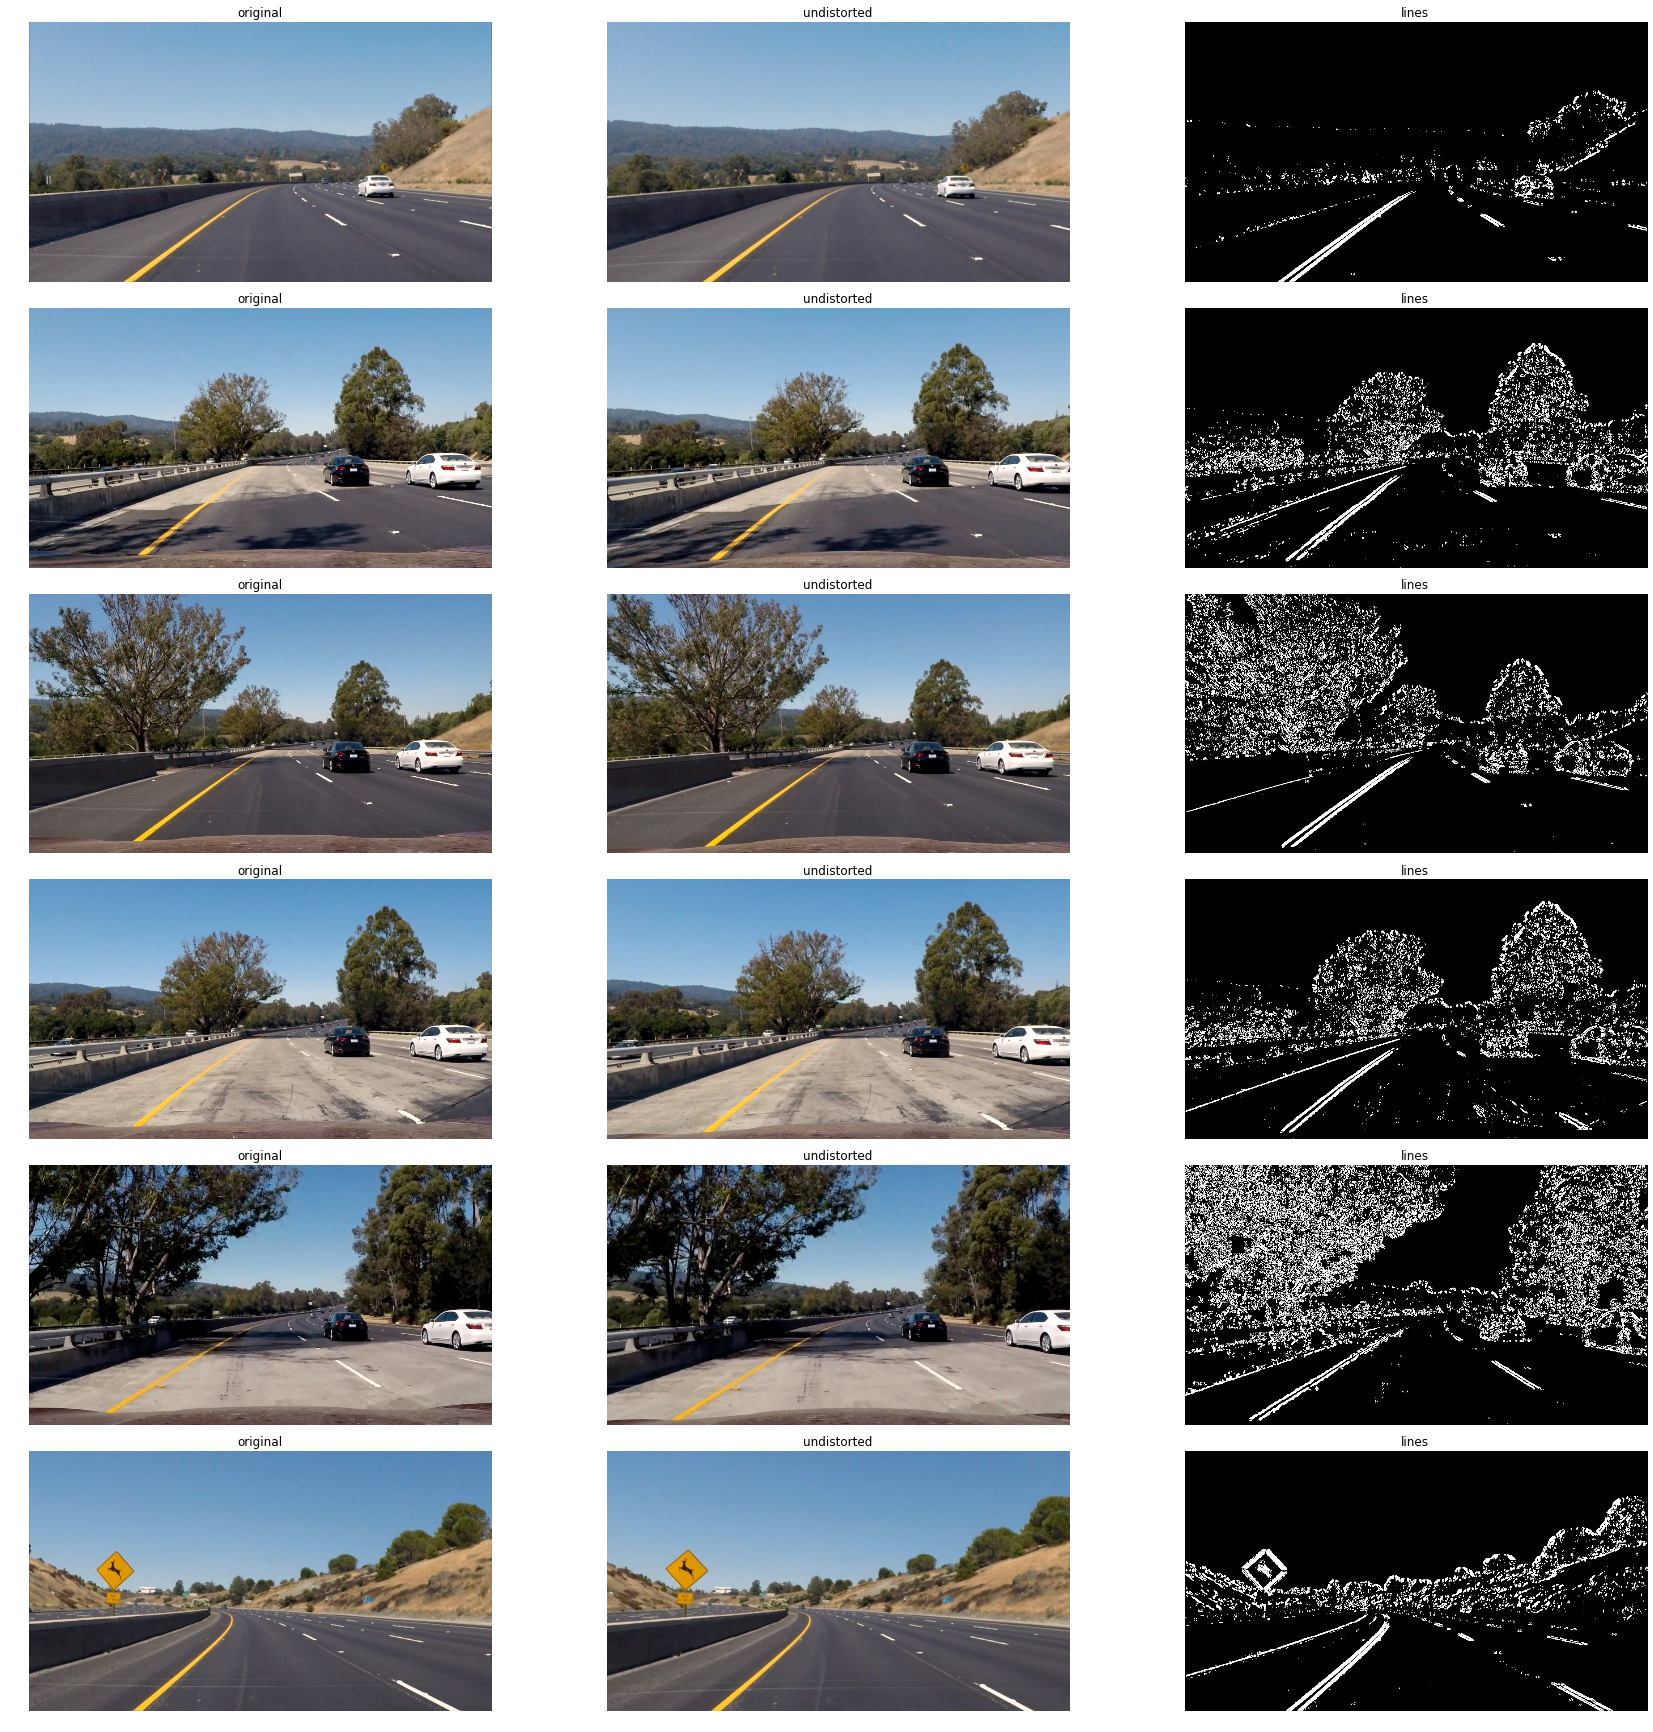

In [16]:
fig, axes = plt.subplots(6, 3, figsize = (8*3, 4*6))
fig.tight_layout()
fig.subplots_adjust(wspace = 0.1, hspace=0.1, )
for ax, test_img in zip(axes, test_imgs):
    ax[0].imshow(test_img)
    ax[0].set_title("original")
    ax[0].set_axis_off()
    
    test_img = cc.undistort(test_img)
    ax[1].imshow(test_img)
    ax[1].set_title("undistorted")
    ax[1].set_axis_off()
    
    lines = line_detector(test_img)
    ax[2].imshow(lines, cmap=plt.cm.gray)
    ax[2].set_title("lines")
    ax[2].set_axis_off()

## 3. Perspective Transform
- based on the class, the perspective matrix can be estimated from a single image and applied to many other, assuming that the road is flat and the camera perspective hasn't changed (really??).
- and it can be tested on new images to see whether the transformed lines are "almost parallel" in bird-eye's view.
- the image used to estimate the perspective transform matrix should be clear and lanes are ideally straight - so it can be easily tested.

### 3.1 trying to get the lines

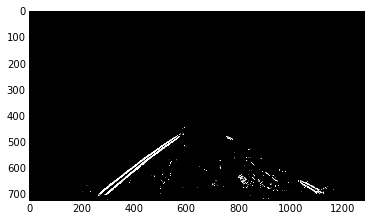

In [17]:
test_img = test_imgs[3]

H, W = test_img.shape[:2]
roi = np.array([[(40,H), (W/2-40, H/2+80), (W/2+40, H/2+80),(W-40,H)]], dtype=np.int32)

from functools import partial
def crop_roi(bin_img, roi, roi_value=1):
    """Crop the roi region of an image, by masking out the other regions.
    - `bin_img`: a binary image, e.g. an image with detected lines.
    - `roi`: region of interest and other areas will be masked out
    """
    mask = np.zeros_like(bin_img, dtype=np.int32)
    cv2.fillPoly(mask, roi, roi_value)
    masked_img = (bin_img & mask)
    return masked_img

undistort_line = make_pipeline([cc.undistort, line_detector, partial(crop_roi, roi=roi)])
line_img = undistort_line(test_img)
plt.imshow(line_img, cmap = plt.cm.gray)

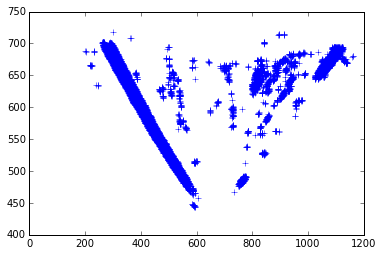

In [18]:
ys, xs = np.where(line_img > 0)
# ys = H - ys
plt.plot(xs, ys, "b+")

In [19]:
from sklearn.cluster import KMeans
cluster2 = KMeans(2)
cluster2.fit(np.c_[xs, ys])

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=2, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

/usr/local/lib/python2.7/dist-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


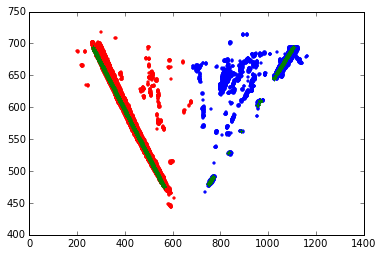

In [20]:
from skimage.measure import LineModel, ransac

linear_models = []
colors = ["r", "b"]
for c, col in enumerate(colors):
    i = (cluster2.labels_ == c)
    
    robust_model, inliers = ransac(np.c_[xs[i], ys[i]], LineModel, 
                                min_samples=2, residual_threshold=1., max_trials=500)
    linear_models.append(robust_model)
    plt.scatter(xs[i], ys[i], color=col, marker=".")
    plt.scatter(xs[i][inliers], ys[i][inliers], color="green", marker="+")

In [21]:
m = linear_models[0]
print(m.params)
print(m.predict_x(H/2))

(716.5332607831607, 0.93679399283314169)
719.975099645


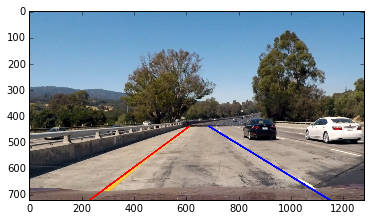

In [54]:
plot_img = test_img.copy()
#plt.imshow(plot_img)
middle_h = H/2+80 #H*3//4
line0 = [(int(linear_models[0].predict_x(H)), H), (int(linear_models[0].predict_x(middle_h)), middle_h)]
line1 = [(int(linear_models[1].predict_x(H)), H), (int(linear_models[1].predict_x(middle_h)), middle_h)]
cv2.line(plot_img, line0[0], line0[1], [255, 0, 0], thickness=5)
cv2.line(plot_img, line1[0], line1[1], [0, 0, 255], thickness=5)
plt.imshow(plot_img)

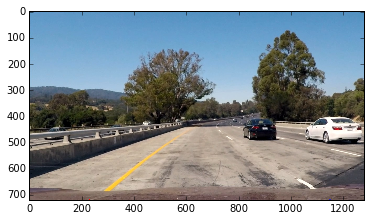

In [55]:
# find source and destination points
middle_h = H/2+60 #H*3/4
line0 = [(linear_models[0].predict_x(H), H), (linear_models[0].predict_x(middle_h), middle_h)]
line1 = [(linear_models[1].predict_x(H), H), (linear_models[1].predict_x(middle_h), middle_h)]
src_pts = np.array(line0 + line1)
bottom_x1, bottom_x2 = line0[0][0], line1[0][0]
v = np.array(line0[1]) - np.array(line0[0])
L = 50*H#int(np.sqrt(np.sum( v*v )))
dst_pts = [(bottom_x1, H), (bottom_x1, H-L),
                   (bottom_x2, H), (bottom_x2, H-L)]

plot_img2 = test_img.copy()
cv2.line(plot_img2, tuple(map(int,dst_pts[0])), tuple(map(int,dst_pts[1])), [255, 0, 0], thickness=5)
cv2.line(plot_img2, tuple(map(int,dst_pts[2])), tuple(map(int,dst_pts[3])), [0, 0, 255], thickness=5)
plt.imshow(plot_img2)

dst_pts = np.array(dst_pts)

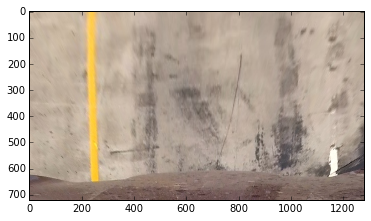

In [56]:
M = cv2.getPerspectiveTransform(src_pts.astype(np.float32), dst_pts.astype(np.float32))
warped_img = cv2.warpPerspective(test_img, M, (W, H), flags=cv2.INTER_LINEAR, )
plt.imshow(warped_img)

In [204]:
class PerspectiveTransformer(object):
    """Perspective Transformation, specially for bird-eye view.
    It fits on a binary image with lines detected, e.g., from result of 
    a LineDetector pipeline, and estimates the transform matrix.
    It transforms new images based on the estimated transform matrix.
    """
    def __init__(self):
        """Constructor
        `PerspectiveTransformer.M`: transform matrix
        """
        self.M = None
    def fit(self, line_img, roi = None):
        """Estimate the tranform matrix self.M based on a binary image
        with line detected.
        - `line_img`: image with two lines detected, representing the 
        left and right boundaries of lanes. In the transformed
        bird-eye view, the two boundaries should be roughly parallel.
        - `roi`: it defines the region of interest where
        the two lane boundaries should be. It should 
        be the vertices of polygon, as used in `cv2.fillPoly`
        By default (None),it uses the whole image as ROI
        """
        # image shape
        H, W = test_img.shape[:2]
        # crop out ROI
        roi_img = line_img.copy()
        if roi is None:
            roi_img = self.crop_roi(roi_img, roi)
        # find line coordinates
        ys, xs = np.where(line_img > 0)
        # clustering of two lines
        cluster2 = KMeans(2)
        cluster2.fit(np.c_[xs, ys])
        # build robust linear model for each line
        linear_models = []
        for c in [0, 1]:
            i = (cluster2.labels_ == c)

            robust_model, inliers = ransac(np.c_[xs[i], ys[i]], LineModel, 
                                        min_samples=2, residual_threshold=1., max_trials=500)
            linear_models.append(robust_model)
        # get the vertices of a trapezoid as source points
        # which will be transformed to rectangles as end points
        line0 = [(int(linear_models[0].predict_x(H)), H), (int(linear_models[0].predict_x(H*3//4)), H*3//4)]
        line1 = [(int(linear_models[1].predict_x(H)), H), (int(linear_models[1].predict_x(H*3//4)), H*3//4)]
        src_pts = np.array(line0 + line1)
        # define destination points
        dst_pts

    def transform(self, img):
        pass
    def crop_roi(self, bin_img, roi, roi_value=1):
        """Crop the roi region of an image, by masking out the other regions.
        - `bin_img`: a binary image, e.g. an image with detected lines.
        - `roi`: region of interest and other areas will be masked out
        - `roi_value`: pixel values to fill the ROI, 1 for binary image, and 255 for gray
        """
        mask = np.zeros_like(bin_img, dtype=np.int32)
        cv2.fillPoly(mask, roi, roi_value)
        masked_img = (bin_img & mask)
        return masked_img

In [205]:
# test Perspective Transformer

test_img = test_imgs[3]
H, W = test_img.shape[:2]

undistort_line = make_pipeline([cc.undistort, line_detector])
line_img = undistort_line(test_img)

trapezoidal_roi = np.array([[(40, H), (W/2-40, H/2+80), 
                             (W/2+40, H/2+80),(W-40,H)]],
                           dtype=np.int32)
pt = PerspectiveTransformer()
pt.fit(line_img, roi = trapezoidal_roi)

/root/anaconda3/lib/python3.5/site-packages/skimage/measure/fit.py:57: skimage_deprecation: `LineModel` is deprecated, use `LineModelND` instead.
  warn(skimage_deprecation('`LineModel` is deprecated, '
